# Problem Description

The goal of this project is to create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans. The data for the project is a slightly modified version of the PatchCamelyon (PCam) benchmark dataset. For each picture, the model must predict if the center 32x32 region contains at least 1 pixel of tumor tissue. 

# Data Analysis

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import keras
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Set tensorflow to use GPU
# import tensorflow as tf
# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.set_visible_devices(physical_devices[0], 'GPU')

# base_path = '/kaggle/input/histopathologic-cancer-detection/'
base_path = './'

In [2]:
labels = pd.read_csv(base_path + 'train_labels.csv')
labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


The data looks to be a csv with a column for the id of the picture and a label of 0 or 1 for whether the center 32x32 region of the picture contains tumor tissue. 

In [3]:
labels.describe()

,label
count,220025.000000
mean,0.405031
std,0.490899
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


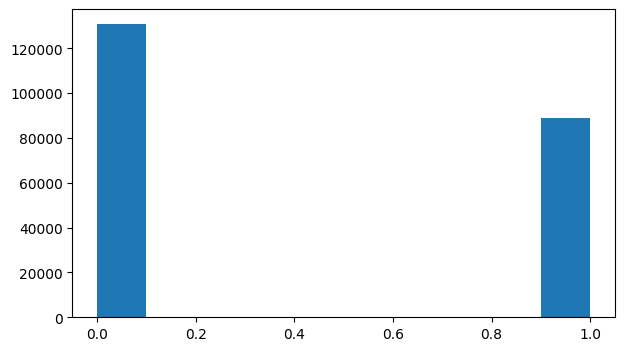

In [4]:
plt.figure(figsize = (7, 4))
plt.hist(labels['label'])
plt.show()

From the mean that was calculated, it looks like the data is fairly balanced with ~60% of the data being negatives and ~40% being positives.

In [5]:
pcam_pictures = os.listdir(base_path + 'train')
pcam_pictures[:5]

['00001b2b5609af42ab0ab276dd4cd41c3e7745b5.tif',
 '000020de2aa6193f4c160e398a8edea95b1da598.tif',
 '00004aab08381d25d315384d646f5ce413ea24b1.tif',
 '0000d563d5cfafc4e68acb7c9829258a298d9b6a.tif',
 '0000da768d06b879e5754c43e2298ce48726f722.tif']

In [6]:
for i in range(10):
    image = cv2.imread(base_path + 'train/' + pcam_pictures[i])
    print(image.shape)

(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)


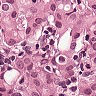

In [7]:
image = Image.open(base_path + 'train/' + pcam_pictures[0])
display(image)

Taking a look at a picture, I can see that they are 96x96 rgb pictures. However, taking a look at a few pictures, they appear to be mainly shades of red and white, so color may not be as important. 

To help with training the model, I will scale the pixel data by dividing by 255, then subtract 0.5 so that the range is centered at 0. 

# Model Architecture

My model architecture will have an input layer that takes in the (96, 96, 3) inputs. To keep things simple so that raw inputs for the model won't need to be scaled, I added a scaling layer to divide the input by 255 and subtract 0.5. 

I tried a few different models. To start with, I created a model with 3 CNN layers with 32 filters each and a flatten layer at the end to feed into the dense output layer. I didn't add any padding since the main problem was to determine whether the center 32x32 pixels showed cancer cells. Relu activation functions were used for the CNN layers, and a sigmoid function was used for the output layer since this is a binary classification problem. Afterwards, the labels of 0/1 will be assigned by rounding the outputs. 

To build off the simple model, I then add to it by

- Add more filters (Detect more features)
- Add MaxPooling and Dropout (Reduce dimensionality with pooling and add some regularization with dropout)
- Add regularization to the CNN layers and reduce Dropout (Add a different form of regularization)

The idea behind the models is to add more complexity while adding ways to help with potential overfitting issues that may arise. 

To help with training, the Adam optimizer was used to adjust the learning rates during training. 

Due to training time, I first trained each model with 5 epochs with the base learning rate of 0.001. Afterwards, I doubled the epochs to 10 since I found that it would complete just before my Kaggle compute time limitations, as well as doubled the base learning rate. The CNN model with increasing filters was not able to finish 10 epochs within 12 hours, so to avoid the complication of training the model in multiple runs, it was discarded. 

### Data Setup

In [8]:
# class ImageDataset(keras.utils.PyDataset):
#     def __init__(self, image_filenames, labels_data, batch_size, base_path, shuffle=True):
#         super().__init__()
#         self.image_filenames = image_filenames
#         self.labels_data = labels_data
#         self.batch_size = batch_size
#         self.base_path = base_path
#         self.shuffle = shuffle
#         self.indices = np.arange(len(self.image_filenames))
#         if self.shuffle:
#             np.random.shuffle(self.indices)
        
#     def __len__(self):
#         return int(np.ceil(len(self.image_filenames) / self.batch_size))
    
#     def __getitem__(self, idx):
#         batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
#         batch_filenames = [self.image_filenames[i] for i in batch_indices]
        
#         images = np.zeros((len(batch_filenames), 96, 96, 3), dtype=np.float32)
#         labels_batch = np.zeros(len(batch_filenames), dtype=np.float32)
        
#         for i, img_name in enumerate(batch_filenames):
#             path = self.base_path + 'train/' + img_name
#             image = keras.preprocessing.image.load_img(path)
#             image = keras.preprocessing.image.img_to_array(image)
#             images[i] = image
            
#             y_val = self.labels_data[self.labels_data['id'] == img_name.replace('.tif', '')]['label'].values[0]
#             labels_batch[i] = int(y_val)
            
#         return images, labels_batch
    
#     def on_epoch_end(self):
#         if self.shuffle:
#             np.random.shuffle(self.indices)

# # Random split with stratification to keep the data balanced
# train_filenames, val_filenames = train_test_split(
#     pcam_pictures, 
#     test_size=0.1, 
#     random_state=37,
#     stratify=[labels[labels['id'] == img.replace('.tif', '')]['label'].values[0] 
#               for img in pcam_pictures]
# )

# # Create datasets
# train_dataset = ImageDataset(train_filenames, labels, 64, base_path, shuffle=True)
# val_dataset = ImageDataset(val_filenames, labels, 64, base_path, shuffle=False)

### Small 3 Layer CNN Model

In [9]:
input_shape = (96, 96, 3)

# Input layer
input_layer = keras.layers.Input(shape = input_shape)

# Normalize the input data
rescale = keras.layers.Rescaling(scale=1./255, offset=-0.5)(input_layer)

# Normalize the brightness of each picture
# normalize = keras.layers.LayerNormalization(axis=[1, 2, 3])(rescale)

# Convolution layers
conv0 = keras.layers.Conv2D(filters = 32, kernel_size = 3, padding = 'valid', activation = 'relu')(rescale)
conv1 = keras.layers.Conv2D(filters = 32, kernel_size = 3, padding = 'valid', activation = 'relu')(conv0)
conv2 = keras.layers.Conv2D(filters = 32, kernel_size = 3, padding = 'valid', activation = 'relu')(conv1)

# Flatten the convolution layer outputs
flatten = keras.layers.Flatten()(conv2)

# Output layer with sigmoid activation for binary classification
output_layer = keras.layers.Dense(units = 1, activation = 'sigmoid')(flatten)

# Create the model
model_conv_small = keras.Model(inputs = input_layer, outputs = output_layer)

model_conv_small.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 92, 92, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 90, 90, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 259200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │         259,201 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 278,593 (1.06 MB)

 Trainable params: 278,593 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# # Early stop if the validation accuracy plateaus or gets worse
# early_stopping = keras.callbacks.EarlyStopping(
#     monitor='val_accuracy',
#     patience=3,
#     restore_best_weights=True,
#     mode='max',
#     min_delta=0.01  # Optional: requires at least 1% improvement
# )

# epochs = 10

# model_conv_small.compile(
#     loss="binary_crossentropy", 
#     optimizer=keras.optimizers.Adam(learning_rate=0.001),
#     metrics=["accuracy"]
# )

# model_conv_small.fit(
#     train_dataset, 
#     epochs=epochs, 
#     validation_data=val_dataset,
#     callbacks=[early_stopping] 
# )

# # Reduce learning rate when plateauing 
# reduce_lr = keras.callbacks.ReduceLROnPlateau(
#     monitor='val_accuracy',
#     factor=0.5,  # Reduce LR by half
#     patience=3,  # Wait 3 epochs before reducing
#     min_lr=1e-7,
#     mode='max',
#     verbose=1
# )

# # Train with both callbacks
# model_conv_small.fit(
#     train_dataset, 
#     epochs=epochs, 
#     validation_data=val_dataset,
#     callbacks=[reduce_lr, early_stopping]  # LR reduction happens first
# )

In [11]:
# model_conv_small.save('/kaggle/working/model_conv_small10.keras') 
# model_conv_small.save('/kaggle/working/model_conv_small10.h5') 

### 3 Layer CNN Model With More Filters

In [12]:
input_shape = (96, 96, 3)

# Input layer
input_layer = keras.layers.Input(shape = input_shape)

# Normalize the input data
rescale = keras.layers.Rescaling(1./255)(input_layer)

# Convolution layers
conv0 = keras.layers.Conv2D(filters = 32, kernel_size = 3, padding = 'valid', activation = 'relu')(rescale)
conv1 = keras.layers.Conv2D(filters = 64, kernel_size = 3, padding = 'valid', activation = 'relu')(conv0)
conv2 = keras.layers.Conv2D(filters = 128, kernel_size = 3, padding = 'valid', activation = 'relu')(conv1)

# Flatten the convolution layer outputs
flatten = keras.layers.Flatten()(conv2)

# Output layer with sigmoid activation for binary classification
output_layer = keras.layers.Dense(units = 1, activation = 'sigmoid')(flatten)

# Create the model
model_conv_only = keras.Model(inputs = input_layer, outputs = output_layer)

model_conv_only.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 92, 92, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 90, 90, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1036800)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │       1,036,801 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,130,049 (4.31 MB)

 Trainable params: 1,130,049 (4.31 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# # Early stop if the validation accuracy plateaus or gets worse
# early_stopping = keras.callbacks.EarlyStopping(
#     monitor='val_accuracy',
#     patience=3,               
#     restore_best_weights=True,
#     mode='max',
#     min_delta=0.01  # Optional: requires at least 1% improvement
# )

# epochs = 10

# model_conv_only.compile(
#     loss="binary_crossentropy", 
#     optimizer=keras.optimizers.Adam(learning_rate=0.002),    # Adam default is 0.001
#     metrics=["accuracy"])

# model_conv_only.fit(
#     train_dataset,
#     epochs=epochs,
#     validation_data=val_dataset,
#     callbacks=[early_stopping]
# )

In [14]:
# model_conv_only.save('/kaggle/working/model_conv_only10.keras') 
# model_conv_only.save('/kaggle/working/model_conv_only10.h5')

### Add MaxPooling and Dropout

In [15]:
input_shape = (96, 96, 3)

# Input layer
input_layer = keras.layers.Input(shape = input_shape)

# Normalize the input data
rescale = keras.layers.Rescaling(1./255)(input_layer)

conv0 = keras.layers.Conv2D(filters = 32, kernel_size = 3, padding = 'valid', activation = 'relu')(rescale)
pool0 = keras.layers.MaxPooling2D(pool_size = 2)(conv0)
conv1 = keras.layers.Conv2D(filters = 64, kernel_size = 3, padding = 'valid', activation = 'relu')(pool0)
pool1 = keras.layers.MaxPooling2D(pool_size = 2)(conv1)
conv2 = keras.layers.Conv2D(filters = 128, kernel_size = 3, padding = 'valid', activation = 'relu')(pool1)
pool2 = keras.layers.MaxPooling2D(pool_size = 2)(conv2)

# Flatten the convolution layer outputs
flatten = keras.layers.Flatten()(pool2)

# Dropout before output layer
dropout = keras.layers.Dropout(0.5)(flatten)

# Output layer with sigmoid activation for binary classification
output_layer = keras.layers.Dense(units = 1, activation = 'sigmoid')(dropout)

# Create the model
model_conv_pool_dropout = keras.Model(inputs = input_layer, outputs = output_layer)

model_conv_pool_dropout.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_2 (Rescaling)              │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 20, 20, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │          12,801 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 106,049 (414.25 KB)

 Trainable params: 106,049 (414.25 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# # Early stop if the validation accuracy plateaus or gets worse
# early_stopping = keras.callbacks.EarlyStopping(
#     monitor='val_accuracy',
#     patience=3,               
#     restore_best_weights=True,
#     mode='max',
#     min_delta=0.01  # Optional: requires at least 1% improvement
# )

# epochs = 10

# model_conv_pool_dropout.compile(
#     loss="binary_crossentropy", 
#     optimizer=keras.optimizers.Adam(learning_rate=0.002),    # Adam default is 0.001
#     metrics=["accuracy"])

# model_conv_pool_dropout.fit(
#     train_dataset,
#     epochs=epochs,
#     validation_data=val_dataset,
#     callbacks=[early_stopping]
# )

In [17]:
# model_conv_pool_dropout.save('/kaggle/working/model_conv_pool_dropout10.keras') 
# model_conv_pool_dropout.save('/kaggle/working/model_conv_pool_dropout10.h5')

### Add Regularization

In [18]:
input_shape = (96, 96, 3)

# Input layer
input_layer = keras.layers.Input(shape = input_shape)

# Normalize the input data
rescale = keras.layers.Rescaling(1./255)(input_layer)

conv0 = keras.layers.Conv2D(filters = 32, kernel_size = 3, padding = 'valid', activation = 'relu', kernel_regularizer = keras.regularizers.l2(0.01))(rescale)
pool0 = keras.layers.MaxPooling2D(pool_size = 2)(conv0)
conv1 = keras.layers.Conv2D(filters = 64, kernel_size = 3, padding = 'valid', activation = 'relu', kernel_regularizer = keras.regularizers.l2(0.01))(pool0)
pool1 = keras.layers.MaxPooling2D(pool_size = 2)(conv1)
conv2 = keras.layers.Conv2D(filters = 128, kernel_size = 3, padding = 'valid', activation = 'relu', kernel_regularizer = keras.regularizers.l2(0.01))(pool1)
pool2 = keras.layers.MaxPooling2D(pool_size = 2)(conv2)

# Flatten the convolution layer outputs
flatten = keras.layers.Flatten()(pool2)

# Dropout before output layer
dropout = keras.layers.Dropout(0.3)(flatten)

# Output layer with sigmoid activation for binary classification
output_layer = keras.layers.Dense(units = 1, activation = 'sigmoid')(dropout)

# Create the model
model_conv_reg_dropout = keras.Model(inputs = input_layer, outputs = output_layer)

model_conv_reg_dropout.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_3 (Rescaling)              │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 20, 20, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │          12,801 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 106,049 (414.25 KB)

 Trainable params: 106,049 (414.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# # Early stop if the validation accuracy plateaus or gets worse
# early_stopping = keras.callbacks.EarlyStopping(
#     monitor='val_accuracy',
#     patience=3,               
#     restore_best_weights=True,
#     mode='max',
#     min_delta=0.01  # Optional: requires at least 1% improvement
# )

# epochs = 10

# model_conv_reg_dropout.compile(
#     loss="binary_crossentropy", 
#     optimizer=keras.optimizers.Adam(learning_rate=0.002),    # Adam default is 0.001
#     metrics=["accuracy"])

# model_conv_reg_dropout.fit(
#     train_dataset,
#     epochs=epochs,
#     validation_data=val_dataset,
#     callbacks=[early_stopping]
# )

In [20]:
# model_conv_reg_dropout.save('/kaggle/working/model_conv_reg_dropout10.keras') 
# model_conv_reg_dropout.save('/kaggle/working/model_conv_reg_dropout10.h5')

# Results and Analysis

In [21]:
model_files = [
    'model_conv_small.keras',
    'model_conv_only.keras',
    'model_conv_pool_dropout.keras',
    'model_conv_reg_dropout.keras',
    'model_conv_pool_dropout10.keras',
    'model_conv_reg_dropout10.keras'
]

In [22]:
# Set up test data
test_pictures = os.listdir(base_path + 'test')

input_images = np.zeros((len(test_pictures), 96, 96, 3), dtype=np.float32)
name_list = []

for i, img in enumerate(test_pictures):
    path = 'test/' + img
    image = keras.preprocessing.image.load_img(path)
    image = keras.preprocessing.image.img_to_array(image)
    input_images[i] = image
    name = img.replace('.tif', '')
    name_list = name_list + [name]

In [24]:
for m in model_files:
    model = keras.models.load_model(m)
    res = model.predict(input_images)
    res = res >= 0.5
    res = pd.DataFrame(res)
    res.columns = ['label']
    res['label'] = res['label'].astype(int)
    res['id'] = name_list
    res.to_csv(m + '.csv', index = False)

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 33s 18ms/step
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 126s 70ms/step
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step


From the results, the architecture with 3 convolution layers with increasing filters and maxpooling layers in between with dropout performed the best. 




| Model | Score |
| -------- | ------- |
| 3 CNN Small (5 Epochs) | 0.7948 |
| 3 CNN Big (5 Epochs) | 0.7467 |
| 3 CNN 3 Pool Dropout (5 Epochs) | 0.8747 |
| 3 CNN 3 Pool Dropout (6 Epochs 2$\alpha$) | 0.8292 |
| 3 CNN 3 Pool L2 Dropout (5 Epochs) | 0.7437 |
| 3 CNN 3 Pool L2 Dropout (5 Epochs 2$\alpha$) | 0.7815 |





In [26]:
conv_small_training = pd.read_csv('conv_small_training.csv')
conv_pool_dropout_training_10 = pd.read_csv('conv_pool_dropout_training_10.csv')
conv_reg_dropout_training_10 = pd.read_csv('conv_reg_dropout_training_10.csv')
conv_big_training = pd.read_csv('conv_big_training_5.csv')
conv_pool_dropout_training_5 = pd.read_csv('conv_pool_dropout_training_5.csv')
conv_reg_dropout_training_5 = pd.read_csv('conv_reg_dropout_training_5.csv')

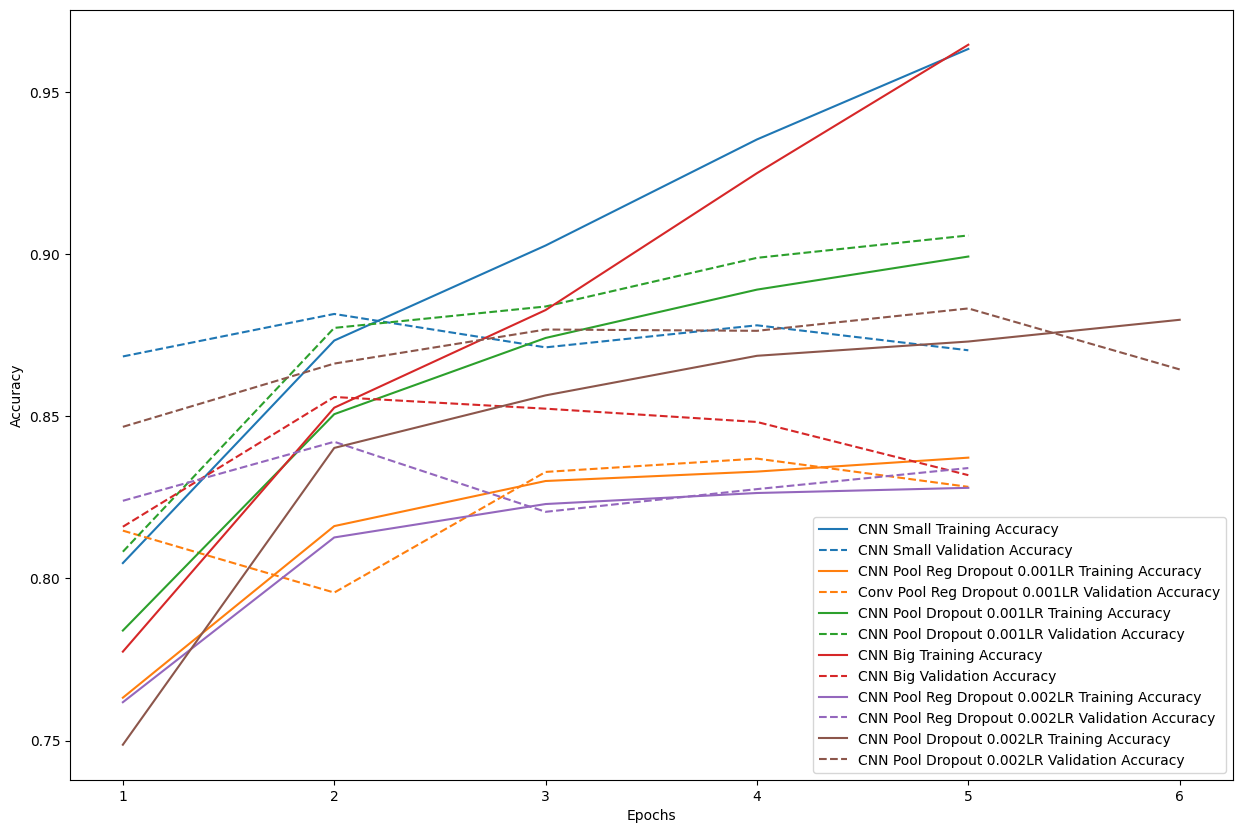

In [33]:
plt.figure(figsize=(15, 10))

# Conv Small - same color for both
plt.plot(conv_small_training['epoch'], conv_small_training['accuracy'], 
         color='C0', label='CNN Small Training Accuracy')
plt.plot(conv_small_training['epoch'], conv_small_training['val_accuracy'], 
         '--', color='C0', label='CNN Small Validation Accuracy')

# Conv Reg Dropout 5 - same color for both
plt.plot(conv_reg_dropout_training_5['epoch'], conv_reg_dropout_training_5['accuracy'], 
         color='C1', label='CNN Pool Reg Dropout 0.001LR Training Accuracy')
plt.plot(conv_reg_dropout_training_5['epoch'], conv_reg_dropout_training_5['val_accuracy'], 
         '--', color='C1', label='Conv Pool Reg Dropout 0.001LR Validation Accuracy')

# Conv Pool Dropout 5 - same color for both
plt.plot(conv_pool_dropout_training_5['epoch'], conv_pool_dropout_training_5['accuracy'], 
         color='C2', label='CNN Pool Dropout 0.001LR Training Accuracy')
plt.plot(conv_pool_dropout_training_5['epoch'], conv_pool_dropout_training_5['val_accuracy'], 
         '--', color='C2', label='CNN Pool Dropout 0.001LR Validation Accuracy')

# Conv Big - same color for both
plt.plot(conv_big_training['epoch'], conv_big_training['accuracy'], 
         color='C3', label='CNN Big Training Accuracy')
plt.plot(conv_big_training['epoch'], conv_big_training['val_accuracy'], 
         '--', color='C3', label='CNN Big Validation Accuracy')

# Conv Reg Dropout 10 - same color for both
plt.plot(conv_reg_dropout_training_10['epoch'], conv_reg_dropout_training_10['accuracy'], 
         color='C4', label='CNN Pool Reg Dropout 0.002LR Training Accuracy')
plt.plot(conv_reg_dropout_training_10['epoch'], conv_reg_dropout_training_10['val_accuracy'], 
         '--', color='C4', label='CNN Pool Reg Dropout 0.002LR Validation Accuracy')

# Conv Pool Dropout 10 - same color for both
plt.plot(conv_pool_dropout_training_10['epoch'], conv_pool_dropout_training_10['accuracy'], 
         color='C5', label='CNN Pool Dropout 0.002LR Training Accuracy')
plt.plot(conv_pool_dropout_training_10['epoch'], conv_pool_dropout_training_10['val_accuracy'], 
         '--', color='C5', label='CNN Pool Dropout 0.002LR Validation Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

From the training results, I can see that there is overfitting happening. The blue lines showing the training accuracy and validation accuracy for the "simple" model, with 3 convolution layers with 32 filters each shows the training accuracy increasing constantly, while the validation accuracy starts dropping after the 2nd epoch. The same can be said to the 3 convolution layers model with increasing filters shown in red. This is expected, since if the smaller model is overfitting, the more complicated model will also overfit. 

The overly complex model with 3 convolution layers of increasing filters and L2 regularization, 3 maxpooling layers, and dropout seemed to have trouble learning the data as shown from the purple and orange lines. Even with the higher base learning rate, both performed similarly in how their training and validation accuracy behaved. Due to both having issues learning, the early stopping kept it at 5 epochs for both runs. 

The best performing model, which was the 3 convolution layers of increasing filters, 3 maxpooling layers, and dropout, showed a consistant increase in both training and validation accuracy, shown by the green and brown lines. Surprisingly, the validation accuracy was higher than the training accuracy, which may indicate that it was generalizing well. However, doubling the base learning rate seems to have hurt performance. The higher learning rate likely made it harder for the model to converge. 

# Conclusion

In conclusion, the best performing model was one with maxpooling and dropout to help with feature extraction and overfitting. The dataset was large, so it was very easy for models to overfit. This can be seen from the training accuracy for the simple models without any regularization or features to help with overfitting, as training accuracy continues improving but validation accuracy decreases or plateaus. Additionally, too much regularization did not help and caused the model to have trouble learning. 

If I spend more time on this project, I would try training the best performing model with more epochs and lower the aggressive early stopping since it kept all models from training more than 6 epochs. A lower learning rate is also beneficial as seen between the difference in performance between the same models with different learning rates. I would also try processing the input data a bit more and remove the brightness aspect, since all the images were just various shades of red, and the different brightnesses could be seen as noise. 

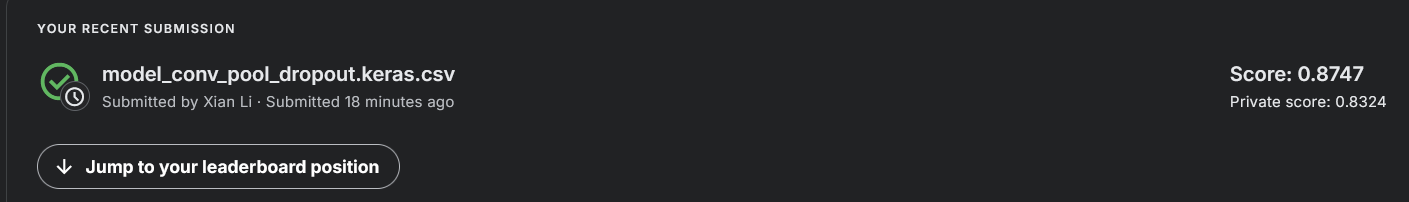